In [2]:
from keras.datasets import mnist
from keras.layers import Input, Conv2D, MaxPool2D, Reshape, Dense, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
(xTrain0, yTrain0), (xTest0, yTest0) = mnist.load_data()
xTrain0 = xTrain0[:10000]
xTrain0, xTest0 = xTrain0/255., xTest0/255.
print(xTrain0.shape, yTrain0.shape, xTest0.shape, yTest0.shape)

(10000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
xTrain, xTest = np.zeros((10000,32,32)), np.zeros((10000,32,32))
for i in range(10000):
    xTrain[i] = cv2.resize(xTrain0[i], (32,32), interpolation=cv2.INTER_CUBIC)
    xTest[i] = cv2.resize(xTest0[i], (32,32), interpolation=cv2.INTER_CUBIC)
xTrain = xTrain.reshape(10000,32,32,1)
xTest = xTest.reshape(10000,32,32,1)

In [9]:
input_layer = Input(shape=(32,32,1))
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)

x = Reshape(target_shape=(1024,))(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
bn = Dense(10, name='bottle_neck', activation='relu')(x)
x = Dense(64, activation='relu')(bn)
x = Dense(256, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Reshape(target_shape=(8,8,16))(x)

x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
output_layer = Conv2D(filters=1, kernel_size=(3,3), padding='same')(x)

encoder = Model(input_layer, bn)
autoencoder = Model(input_layer, output_layer) #output_layer
encoder.summary()
autoencoder.summary()
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mse')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2624

In [10]:
history = autoencoder.fit(xTrain, xTrain, epochs=10, batch_size=128, shuffle=True, \
    validation_data=(xTest, xTest))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 15s 1ms/step - loss: 0.0773 - val_loss: 0.0648
Epoch 2/10
10000/10000 [==============================] - 16s 2ms/step - loss: 0.0605 - val_loss: 0.0554
Epoch 3/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0506 - val_loss: 0.0474
Epoch 4/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0444 - val_loss: 0.0411
Epoch 5/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0389 - val_loss: 0.0374
Epoch 6/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0362 - val_loss: 0.0353
Epoch 7/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0343 - val_loss: 0.0338
Epoch 8/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 9/10
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0314 - val_loss: 0.0311
Epoch

In [12]:
history.history

{'val_loss': [0.06484366680383682,
  0.05544042035341263,
  0.0473909191429615,
  0.04110082017183304,
  0.03739842838048935,
  0.03525442961454391,
  0.03376703643202782,
  0.032388710415363314,
  0.031129578775167466,
  0.030120631855726242],
 'loss': [0.07725646644830704,
  0.060539062011241915,
  0.05064190765619278,
  0.044409999245405195,
  0.038943681585788724,
  0.03621613864302635,
  0.03425764846801758,
  0.03275987796187401,
  0.03136429988145828,
  0.030166654512286187]}

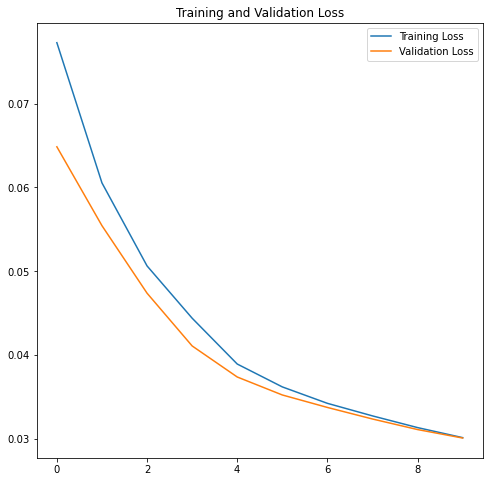

In [13]:
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

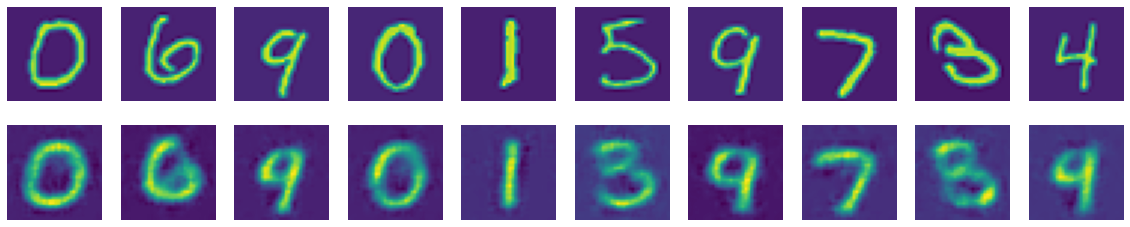

In [24]:
start = 10
pred = autoencoder.predict( xTest[start:start+10] )
pred = pred.reshape(10, 32, 32)

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(xTest[start+i].reshape(32,32))
    plt.axis('off')
    
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(pred[i])
    plt.axis('off')
    
plt.show()

In [25]:
L = encoder.predict( xTest[start:start+10] )
print(L)

[[0.33572763 3.1123722  0.         0.14661963 3.739981   1.6632242
  0.         4.812918   0.         1.8409035 ]
 [0.5067163  2.5875738  0.         1.8719157  1.9923642  1.2532068
  0.         4.1992793  0.         2.375905  ]
 [0.92476326 3.2110913  0.         3.6290245  6.5739765  1.2588022
  0.         3.7010438  0.         2.0087879 ]
 [0.87855345 4.138138   0.         1.5124325  4.1585636  1.060637
  0.         5.1985784  0.         1.9009155 ]
 [0.         4.008077   0.         3.508631   3.6791234  3.8757246
  0.         1.2969046  0.         0.4664108 ]
 [0.5890207  3.9041858  0.         0.29022008 0.83682144 1.5054483
  0.         2.7724845  0.         1.1258754 ]
 [0.53248996 3.1225512  0.         2.7200952  5.601254   0.91587156
  0.         3.5462923  0.         3.2028646 ]
 [0.         1.8947729  0.         0.70132095 7.10219    2.0186417
  0.         1.7650832  0.         2.040938  ]
 [1.256502   5.3485847  0.         1.6354953  0.         1.7582722
  0.         3.279765

In [15]:
autoencoder.save("ae.h5")